#### Customer Journey Optimizer

In [21]:
# ============================================================
# 01-Install & Imports
# ============================================================
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

print("✅ Imports ready.")


✅ Imports ready.


In [22]:
# ============================================================================
# 02: Load and Preview Data
# ============================================================================
# Load the data
df_raw = pd.read_excel("https://raw.githubusercontent.com/Obay11/obay_330405-mhd_tarek_329276/main/data_all.csv")
print("📊 Data loaded successfully!")
print("Raw shape:", df_raw.shape)
print("Columns:", list(df_raw.columns))
df_raw.head()

📊 Data loaded successfully!
Raw shape: (259917, 10)
Columns: ['account_id', 'SourceSystem', 'activity_date', 'who_id', 'opportunity_id', 'opportunity_stage', 'is_lead', 'types', 'Country', 'solution']


,account_id,SourceSystem,activity_date,who_id,opportunity_id,opportunity_stage,is_lead,types,Country,solution
0,0010L00001hVmFhQAK,SFDC_US,2022-07-25,0030L00001vlbHLQAY,NaN,no_opp,1.0,Follow Up,US,MRS
1,0010L00001hVmFhQAK,SFDC_US,2023-02-08,0034X00002xZlQtQAK,NaN,no_opp,1.0,Inbound Call,US,MRS
2,0010L00001hVmFhQAK,SFDC_US,2023-02-14,0030L00001vlbHLQAY,NaN,no_opp,1.0,Inbound Call,US,MRS
3,0010L00001hVmFhQAK,SFDC_US,2023-02-20,0030L00001vlbHLQAY,NaN,no_opp,2.0,Inbound Call,US,MRS
4,0010L00001hVmFhQAK,SFDC_US,2023-03-16,0034X00003GOUrFQAX,NaN,no_opp,1.0,Inbound Call,US,MRS


In [23]:
# ============================================================
# 03: Clean Data (ETL) + Build Journey ID
# ============================================================
df = df_raw.copy()

# Parse date
df["activity_date"] = pd.to_datetime(df["activity_date"], errors="coerce")

# Drop rows missing the minimum fields for journeys
df = df.dropna(subset=["account_id", "activity_date", "types", "Country", "solution"]).copy()

# Standardize strings
for col in ["types", "Country", "solution", "opportunity_stage", "SourceSystem"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Clean is_lead
df["is_lead"] = pd.to_numeric(df.get("is_lead", 0), errors="coerce").fillna(0).astype(int)

# Deduplicate
df = df.drop_duplicates(subset=["account_id", "activity_date", "types", "opportunity_id"])

# Build journey_id correctly:
# - If opportunity_id exists => opportunity journey
# - Else => lead journey per account (NOT a global "no_opp")
df["journey_type"] = np.where(df["opportunity_id"].notna(), "OPP", "LEAD")
df["journey_id"] = np.where(
    df["opportunity_id"].notna(),
    df["account_id"].astype(str) + "::" + df["opportunity_id"].astype(str),
    df["account_id"].astype(str) + "::LEAD"
)

# Sort for sequences
df = df.sort_values(["journey_id", "activity_date"], kind="mergesort").reset_index(drop=True)

print("✅ Cleaned shape:", df.shape)
print("Journey types:\n", df["journey_type"].value_counts())
df.head()


✅ Cleaned shape: (159049, 12)
Journey types:
 journey_type
LEAD    126332
OPP      32717
Name: count, dtype: int64


,account_id,SourceSystem,activity_date,who_id,opportunity_id,opportunity_stage,is_lead,types,Country,solution,journey_type,journey_id
0,0010L00001hVmFhQAK,SFDC_US,2022-07-25,0030L00001vlbHLQAY,NaN,no_opp,1,Follow Up,US,MRS,LEAD,0010L00001hVmFhQAK::LEAD
1,0010L00001hVmFhQAK,SFDC_US,2023-02-08,0034X00002xZlQtQAK,NaN,no_opp,1,Inbound Call,US,MRS,LEAD,0010L00001hVmFhQAK::LEAD
2,0010L00001hVmFhQAK,SFDC_US,2023-02-14,0030L00001vlbHLQAY,NaN,no_opp,1,Inbound Call,US,MRS,LEAD,0010L00001hVmFhQAK::LEAD
3,0010L00001hVmFhQAK,SFDC_US,2023-02-20,0030L00001vlbHLQAY,NaN,no_opp,2,Inbound Call,US,MRS,LEAD,0010L00001hVmFhQAK::LEAD
4,0010L00001hVmFhQAK,SFDC_US,2023-03-16,0034X00003GOUrFQAX,NaN,no_opp,1,Inbound Call,US,MRS,LEAD,0010L00001hVmFhQAK::LEAD


In [24]:
# ============================================================
# 04: Build Sequences + Outcome Mapping
# ============================================================
# Lowercase stage to map outcomes
df["opportunity_stage"] = df.get("opportunity_stage", "no_stage").astype(str).str.strip().str.lower()

def stage_to_outcome(stage: str) -> str:
    if "won" in stage:
        return "WON"
    if "lost" in stage or "disqual" in stage:
        return "LOST"
    return "ONGOING"

df["outcome"] = df["opportunity_stage"].apply(stage_to_outcome)

def compress_consecutive(seq):
    out = []
    for x in seq:
        if not out or out[-1] != x:
            out.append(x)
    return out

# Sequence per journey_id
seq_df = (
    df.groupby("journey_id")
      .agg(
          account_id=("account_id", "first"),
          journey_type=("journey_type", "first"),
          Country=("Country", lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]),
          solution=("solution", lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]),
          SourceSystem=("SourceSystem", lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]),
          is_lead=("is_lead", "max"),
          first_date=("activity_date", "min"),
          last_date=("activity_date", "max"),
          outcome=("outcome", "last"),
          actions=("types", lambda x: compress_consecutive(list(x)))
      )
      .reset_index()
)

seq_df["duration_days"] = (seq_df["last_date"] - seq_df["first_date"]).dt.days.fillna(0).clip(lower=0)
seq_df["path_len"] = seq_df["actions"].apply(len)

print("✅ Sequences built:", seq_df.shape)
seq_df.head()


✅ Sequences built: (20079, 13)


,journey_id,account_id,journey_type,Country,solution,SourceSystem,is_lead,first_date,last_date,outcome,actions,duration_days,path_len
0,0010L00001hVmFhQAK::LEAD,0010L00001hVmFhQAK,LEAD,US,MRS,SFDC_US,2,2022-07-25,2025-06-11,ONGOING,"[Follow Up, Inbound Call]",1052,2
1,0010L00001hVxd6QAC::0060y000019Fk7PAAS,0010L00001hVxd6QAC,OPP,US,MRS,SFDC_US,1,2019-10-10,2019-10-10,WON,[Meeting],0,1
2,0010L00001hVxd6QAC::LEAD,0010L00001hVxd6QAC,LEAD,US,MRS,SFDC_US,2,2019-08-21,2025-05-13,ONGOING,"[Meeting, Review, Email, Review, Email, Inboun...",2092,7
3,0010L00001hVyJQQA0::LEAD,0010L00001hVyJQQA0,LEAD,US,MRS,SFDC_US,2,2021-12-26,2025-08-22,ONGOING,"[Inbound Call, Email, Inbound Call]",1335,3
4,0010L00001hW1cAQAS::LEAD,0010L00001hW1cAQAS,LEAD,US,MRS,SFDC_US,2,2021-12-19,2021-12-19,ONGOING,[Inbound Call],0,1


In [25]:
# ============================================================
# 05: Best + Shorter Top 5 Paths (by Country + solution)
# ============================================================

# Convert action list to a capped path string
K_STEPS = 6
seq_df["path"] = seq_df["actions"].apply(lambda s: " > ".join(s[:K_STEPS]))

# We only score "best paths" using journeys that have a final outcome (WON/LOST) when available
# But we can still count paths for all journeys. We'll compute win rate on final ones only.
final_mask = seq_df["outcome"].isin(["WON", "LOST"])

# Count paths
path_counts = (
    seq_df.groupby(["Country", "solution", "path"])
          .size().reset_index(name="count")
)

# Compute smoothed win rate for each path using final outcomes only
final_df = seq_df[final_mask].copy()
won_counts = (
    final_df.assign(is_won=(final_df["outcome"] == "WON").astype(int))
            .groupby(["Country", "solution", "path"])["is_won"]
            .agg(["sum", "count"])
            .reset_index()
            .rename(columns={"sum": "won", "count": "final_total"})
)

# Laplace smoothing: (won + 1) / (final_total + 2)
won_counts["win_rate_smooth"] = (won_counts["won"] + 1) / (won_counts["final_total"] + 2)

# Mean length (shortness proxy) from all journeys
mean_len = (
    seq_df.groupby(["Country", "solution", "path"])["path_len"]
          .mean().reset_index(name="mean_len")
)

paths_scored = (
    path_counts.merge(won_counts[["Country","solution","path","final_total","win_rate_smooth"]],
                      on=["Country","solution","path"], how="left")
              .merge(mean_len, on=["Country","solution","path"], how="left")
)

paths_scored["final_total"] = paths_scored["final_total"].fillna(0).astype(int)
paths_scored["win_rate_smooth"] = paths_scored["win_rate_smooth"].fillna(0.5)  # neutral if unknown

# Apply minimum support to avoid misleading "100%" small samples
MIN_SUPPORT = 30
paths_scored["support_ok"] = (paths_scored["count"] >= MIN_SUPPORT)

# Score = win_rate_smooth - lambda * normalized length
lam = 0.05
# normalize length roughly
paths_scored["len_norm"] = paths_scored["mean_len"] / (paths_scored["mean_len"].max() if paths_scored["mean_len"].max() else 1)
paths_scored["score"] = paths_scored["win_rate_smooth"] - lam * paths_scored["len_norm"]

# Rank within each segment
paths_scored = paths_scored.sort_values(["Country","solution","score","count"], ascending=[True,True,False,False])
paths_scored["rank"] = paths_scored.groupby(["Country","solution"]).cumcount() + 1

top5_best_paths = paths_scored[paths_scored["rank"] <= 5].copy()

print("✅ Top 5 best+shorter paths computed.")
top5_best_paths.head(20)


✅ Top 5 best+shorter paths computed.


,Country,solution,path,count,final_total,win_rate_smooth,mean_len,support_ok,len_norm,score,rank
0,AT,MRS,Email,72,0,0.500000,1.0,True,0.005464,0.499727,1
4,AT,MRS,Review > Email,2,0,0.500000,2.0,False,0.010929,0.499454,2
1,AT,MRS,Email > 1st Appointment,1,0,0.500000,2.0,False,0.010929,0.499454,3
2,AT,MRS,Email > 2nd Appointment > Email,1,0,0.500000,3.0,False,0.016393,0.499180,4
3,AT,MRS,Email > Follow Up > Email > Demo,1,0,0.500000,4.0,False,0.021858,0.498907,5
5,BE,Digital,Email > Follow Up > Email > Follow Up,1,0,0.500000,4.0,False,0.021858,0.498907,1
12,BE,MRS,Email,47,0,0.500000,1.0,True,0.005464,0.499727,1
35,BE,MRS,Meeting,2,0,0.500000,1.0,False,0.005464,0.499727,2
6,BE,MRS,1st Appointment,1,0,0.500000,1.0,False,0.005464,0.499727,3
13,BE,MRS,Email > 1st Appointment,5,0,0.500000,2.0,False,0.010929,0.499454,4


In [26]:
# ============================================================
# 06: Next-Action Dataset with Context (last 3 actions)
# ============================================================

df_na = df.copy()

# Sequence features per journey
df_na["prev_date"] = df_na.groupby("journey_id")["activity_date"].shift(1)
df_na["days_since_prev"] = (df_na["activity_date"] - df_na["prev_date"]).dt.days.fillna(-1).clip(lower=-1)

df_na["step_index"] = df_na.groupby("journey_id").cumcount() + 1
df_na["next_types"] = df_na.groupby("journey_id")["types"].shift(-1)

# Build last-3 action context
df_na["prev1"] = df_na.groupby("journey_id")["types"].shift(1).fillna("NONE")
df_na["prev2"] = df_na.groupby("journey_id")["types"].shift(2).fillna("NONE")
df_na["prev3"] = df_na.groupby("journey_id")["types"].shift(3).fillna("NONE")

# Keep rows where next action exists
df_na = df_na.dropna(subset=["next_types"]).copy()

print("✅ Next-action dataset ready:", df_na.shape)
df_na.head()


✅ Next-action dataset ready: (138970, 20)


,account_id,SourceSystem,activity_date,who_id,opportunity_id,opportunity_stage,is_lead,types,Country,solution,journey_type,journey_id,outcome,prev_date,days_since_prev,step_index,next_types,prev1,prev2,prev3
0,0010L00001hVmFhQAK,SFDC_US,2022-07-25,0030L00001vlbHLQAY,NaN,no_opp,1,Follow Up,US,MRS,LEAD,0010L00001hVmFhQAK::LEAD,ONGOING,NaT,-1.0,1,Inbound Call,NONE,NONE,NONE
1,0010L00001hVmFhQAK,SFDC_US,2023-02-08,0034X00002xZlQtQAK,NaN,no_opp,1,Inbound Call,US,MRS,LEAD,0010L00001hVmFhQAK::LEAD,ONGOING,2022-07-25,198.0,2,Inbound Call,Follow Up,NONE,NONE
2,0010L00001hVmFhQAK,SFDC_US,2023-02-14,0030L00001vlbHLQAY,NaN,no_opp,1,Inbound Call,US,MRS,LEAD,0010L00001hVmFhQAK::LEAD,ONGOING,2023-02-08,6.0,3,Inbound Call,Inbound Call,Follow Up,NONE
3,0010L00001hVmFhQAK,SFDC_US,2023-02-20,0030L00001vlbHLQAY,NaN,no_opp,2,Inbound Call,US,MRS,LEAD,0010L00001hVmFhQAK::LEAD,ONGOING,2023-02-14,6.0,4,Inbound Call,Inbound Call,Inbound Call,Follow Up
4,0010L00001hVmFhQAK,SFDC_US,2023-03-16,0034X00003GOUrFQAX,NaN,no_opp,1,Inbound Call,US,MRS,LEAD,0010L00001hVmFhQAK::LEAD,ONGOING,2023-02-20,24.0,5,Inbound Call,Inbound Call,Inbound Call,Inbound Call


✅ Next-action DT trained.
Top-4 Accuracy: 0.952
MRR: 0.766

📌 DT Feature Importance (Next-Action Model) — Top 15


,Feature,Importance
33,types_Inbound Call,0.340376
24,SourceSystem_SFDC_ROW,0.134086
31,types_Email,0.133026
44,prev1_Inbound Call,0.052201
34,types_Meeting,0.044343
42,prev1_Email,0.042980
16,Country_US,0.035032
74,days_since_prev,0.028516
35,types_On-Site,0.026261
39,prev1_Call,0.019776


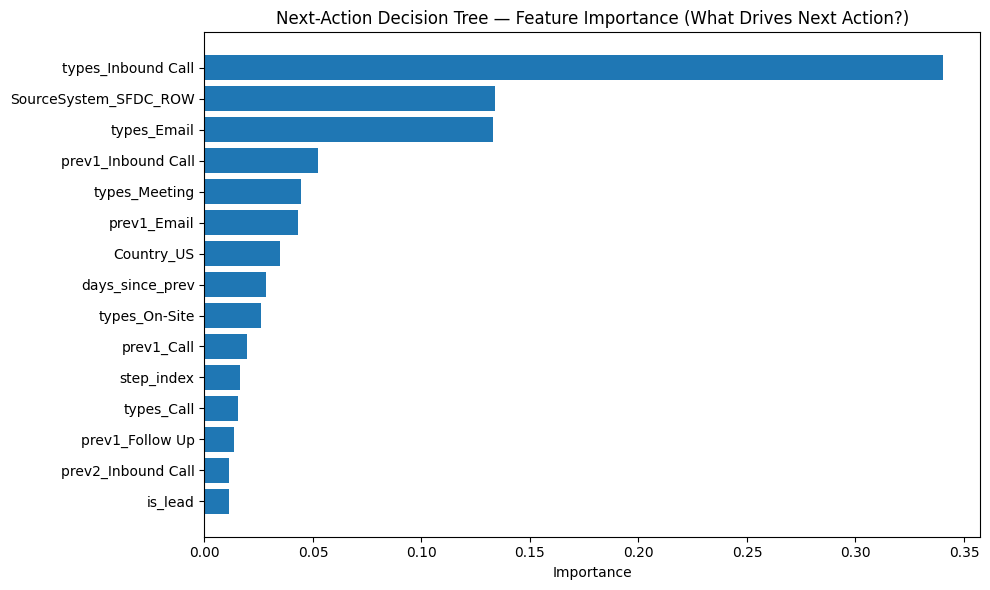


📌 Aggregated importance by feature group (e.g., types vs Country vs prev1...)


,Group,Importance
0,types,0.570494
1,SourceSystem,0.140050
2,prev1,0.133120
3,Country,0.044514
4,prev2,0.040926
5,days,0.028516
6,step,0.016156
7,prev3,0.014045
8,is,0.011159
9,solution,0.001019


In [27]:
# ===============================================================
# 07: Train DT Next-Action + Evaluate + Visual Feature Importance
# ===============================================================

# ----------------------------
# 1) Define Features / Target
# ----------------------------
FEATURES = [
    "Country", "solution", "SourceSystem",
    "types", "prev1", "prev2", "prev3",
    "is_lead", "days_since_prev", "step_index"
]
TARGET = "next_types"

X = df_na[FEATURES].copy()
y = df_na[TARGET].copy()

cat_cols = ["Country", "solution", "SourceSystem", "types", "prev1", "prev2", "prev3"]
num_cols = ["is_lead", "days_since_prev", "step_index"]

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols),
])

dt_next = DecisionTreeClassifier(
    max_depth=14,
    min_samples_leaf=80,
    random_state=42
)

next_model = Pipeline([("pre", pre), ("dt", dt_next)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

next_model.fit(X_train, y_train)

print("✅ Next-action DT trained.")

# ----------------------------
# 2) Top-k evaluation (Top-4 Accuracy + MRR)
# ----------------------------
def topk_metrics(model, X_te, y_te, k=4):
    proba = model.predict_proba(X_te)
    classes = model.named_steps["dt"].classes_
    y_true = y_te.values

    # Top-k accuracy
    topk_idx = np.argsort(-proba, axis=1)[:, :k]
    topk_pred = classes[topk_idx]
    hit = np.mean([y_true[i] in topk_pred[i] for i in range(len(y_true))])

    # MRR
    ranks = []
    for i in range(len(y_true)):
        order = np.argsort(-proba[i])
        ranked = list(classes[order])
        r = ranked.index(y_true[i]) + 1 if y_true[i] in ranked else 10**9
        ranks.append(1 / r)
    mrr = float(np.mean(ranks))

    return float(hit), float(mrr)

top4_acc, mrr = topk_metrics(next_model, X_test, y_test, k=4)

print(f"Top-4 Accuracy: {top4_acc:.3f}")
print(f"MRR: {mrr:.3f}")

# ----------------------------
# 3) Feature Importance (Explainability) + Plot
# ----------------------------
def _get_ohe_feature_names(column_transformer: ColumnTransformer) -> list:
    """
    Extract expanded feature names from ColumnTransformer:
    - OneHotEncoder feature names for categorical part
    - Original numeric names for passthrough numeric part
    """
    names = []
    for name, transformer, cols in column_transformer.transformers_:
        if transformer == "passthrough":
            if isinstance(cols, (list, tuple, np.ndarray)):
                names.extend(list(cols))
            else:
                names.append(str(cols))
        elif hasattr(transformer, "get_feature_names_out"):
            # OneHotEncoder case
            ohe_names = transformer.get_feature_names_out(cols)
            names.extend(list(ohe_names))
    return names

# Get expanded feature names and importances
feat_names = _get_ohe_feature_names(next_model.named_steps["pre"])
importances = next_model.named_steps["dt"].feature_importances_

m = min(len(feat_names), len(importances))
imp_df = pd.DataFrame({
    "Feature": feat_names[:m],
    "Importance": importances[:m]
}).sort_values("Importance", ascending=False)

# Keep non-zero to improve readability
imp_df_nz = imp_df[imp_df["Importance"] > 0].copy()

print("\n📌 DT Feature Importance (Next-Action Model) — Top 15")
display(imp_df_nz.head(15))

# Plot Top-N
TOP_N = 15
plot_df = imp_df_nz.head(TOP_N).iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(plot_df["Feature"], plot_df["Importance"])
plt.xlabel("Importance")
plt.title("Next-Action Decision Tree — Feature Importance (What Drives Next Action?)")
plt.tight_layout()
plt.show()


# ----------------------------
# 4) Business-friendly summary (aggregate by action family)
# ----------------------------
# This helps answer questions like: "Is Email more influential than On-Site?"
# We aggregate importances of one-hot columns that belong to the same original feature group.

def summarize_importance_by_group(imp_df: pd.DataFrame) -> pd.DataFrame:
    def group_name(f):
        # OneHotEncoder features look like: "types_Email" or "Country_US" depending on sklearn version.
        # We map by prefix up to first '_' to represent original column group.
        s = str(f)
        # handle "cat__types_Email" style too
        s = s.replace("cat__", "")
        return s.split("_")[0] if "_" in s else s

    tmp = imp_df.copy()
    tmp["Group"] = tmp["Feature"].apply(group_name)
    grp = tmp.groupby("Group")["Importance"].sum().sort_values(ascending=False).reset_index()
    return grp

grp_imp = summarize_importance_by_group(imp_df_nz)

print("\n📌 Aggregated importance by feature group (e.g., types vs Country vs prev1...)")
display(grp_imp.head(10))


In [28]:
# ============================================================
# 08: Build FULL segment action table + Top-4 views
# ============================================================

def top_actions_full_final_opp(
    df_na: pd.DataFrame,
    group_cols,
    min_support: int = 30,
    alpha: float = 0.7,   # win_rate weight
    beta: float = 0.3     # count weight
):
    """
    Build a FULL action table per segment:
    - 'count' from ALL rows (LEAD+OPP)
    - 'win_rate_smooth' from FINAL OPP only (WON/LOST)
    - 'score' = alpha*win_rate + beta*count_norm
    Returns ALL actions per segment (not top-k).
    """

    # Ensure journey_type/outcome exist
    needed_cols = {"journey_id", "journey_type", "outcome"}
    if not needed_cols.issubset(set(df_na.columns)):
        raise ValueError("df_na must include journey_type and outcome columns.")

    # 1) Overall counts (all rows)
    counts_all = (
        df_na.groupby(group_cols + ["next_types"])
             .size().reset_index(name="count_all")
    )

    # 2) FINAL opportunities only
    final_opp = df_na[(df_na["journey_type"] == "OPP") & (df_na["outcome"].isin(["WON", "LOST"]))].copy()
    final_opp["is_won"] = (final_opp["outcome"] == "WON").astype(int)

    win_stats = (
        final_opp.groupby(group_cols + ["next_types"])
                 .agg(count_final=("next_types","size"), won=("is_won","sum"))
                 .reset_index()
    )
    win_stats["win_rate_smooth"] = (win_stats["won"] + 1) / (win_stats["count_final"] + 2)

    # 3) Merge
    out = counts_all.merge(win_stats, on=group_cols + ["next_types"], how="left")
    out["count_final"] = out["count_final"].fillna(0).astype(int)
    out["won"] = out["won"].fillna(0).astype(int)
    out["win_rate_smooth"] = out["win_rate_smooth"].fillna(0.5)

    # 4) Support filter (operational volume)
    out = out[out["count_all"] >= min_support].copy()

    # 5) Score
    max_c = out["count_all"].max() if len(out) else 1
    out["count_norm"] = out["count_all"] / max_c
    out["score"] = alpha * out["win_rate_smooth"] + beta * out["count_norm"]

    # Rename for consistent printing
    out = out.rename(columns={"count_all": "count"})
    return out

# Make sure df_na has journey_type/outcome; merge from df if needed
if "journey_type" not in df_na.columns or "outcome" not in df_na.columns:
    df_na = df_na.merge(df[["journey_id","journey_type","outcome"]].drop_duplicates(), on="journey_id", how="left")

# FULL tables (all actions)
seg_actions_country_full = top_actions_full_final_opp(df_na, ["Country"], min_support=30)
seg_actions_solution_full = top_actions_full_final_opp(df_na, ["solution"], min_support=30)
seg_actions_country_solution_full = top_actions_full_final_opp(df_na, ["Country","solution"], min_support=30)

# Top-4 views for display
def take_topk(table_df, group_cols, k=4):
    t = table_df.sort_values(group_cols + ["score","count"], ascending=[True]*len(group_cols)+[False,False]).copy()
    t["rank"] = t.groupby(group_cols).cumcount() + 1
    return t[t["rank"] <= k].drop(columns=["rank"]).reset_index(drop=True)

top4_by_country = take_topk(seg_actions_country_full, ["Country"], k=4)
top4_by_solution = take_topk(seg_actions_solution_full, ["solution"], k=4)
top4_by_country_solution = take_topk(seg_actions_country_solution_full, ["Country","solution"], k=4)

print("✅ FULL segment tables + Top-4 views are ready.")
top4_by_country_solution.head(20)


✅ FULL segment tables + Top-4 views are ready.


,Country,solution,next_types,count,count_final,won,win_rate_smooth,count_norm,score
0,AT,MRS,Email,197,0,0,0.500000,0.006153,0.351846
1,BE,MRS,Email,337,0,0,0.500000,0.010525,0.353158
2,CA,MRS,Email,399,0,0,0.500000,0.012462,0.353739
3,CA,MRS,Follow Up,131,0,0,0.500000,0.004091,0.351227
4,CA,MRS,Meeting,124,0,0,0.500000,0.003873,0.351162
5,CA,MRS,Review,35,0,0,0.500000,0.001093,0.350328
6,CH,MRS,Email,381,0,0,0.500000,0.011900,0.353570
7,DE,MRS,Email,3247,0,0,0.500000,0.101412,0.380424
8,DE,MRS,2nd Appointment,387,0,0,0.500000,0.012087,0.353626
9,DE,MRS,1st Appointment,246,0,0,0.500000,0.007683,0.352305


In [29]:
# ============================================================
# 09: Dynamic Weight Engine (stronger but stable)
# ============================================================

class DynamicWeightEngine:
    """
    Stable reweighting:
    - memory[action] in [0..1]
    - recently used action gets a smooth penalty (not zero)
    - penalties decay over time
    """

    def __init__(self, gamma=0.35, decay=0.80, min_factor=0.40):
        self.gamma = gamma
        self.decay = decay
        self.min_factor = min_factor
        self.memory = {}  # action -> memory

    def update(self, chosen_action: str):
        # Decay all memories
        for a in list(self.memory.keys()):
            self.memory[a] *= self.decay

        # Boost chosen action memory
        self.memory[chosen_action] = min(1.0, self.memory.get(chosen_action, 0.0) + self.gamma)

    def reweight(self, base_scores: dict) -> dict:
        adjusted = {}
        for a, s in base_scores.items():
            penalty_factor = max(self.min_factor, 1.0 - self.memory.get(a, 0.0))
            adjusted[a] = s * penalty_factor

        total = sum(adjusted.values()) or 1.0
        return {a: v / total for a, v in adjusted.items()}

print("✅ DynamicWeightEngine updated (stronger last-touch effect).")


✅ DynamicWeightEngine updated (stronger last-touch effect).


In [30]:
# ============================================================
# 10: Recommendation System (prints richer info + weighted)
# ============================================================

def get_top4_rows(table_df: pd.DataFrame, filters: dict):
    sub = table_df.copy()
    for k, v in filters.items():
        sub = sub[sub[k] == v]
    if sub.empty:
        return sub
    return sub.sort_values(["score", "count"], ascending=[False, False]).head(4)

class CustomerJourneySystem:
    def __init__(self, top_country_df, top_solution_df, top_country_solution_df):
        self.top_country_df = top_country_df
        self.top_solution_df = top_solution_df
        self.top_country_solution_df = top_country_solution_df
        self.engine = DynamicWeightEngine(gamma=0.35, decay=0.80, min_factor=0.40)

    def recommend_tables(self, Country: str, solution: str):
        r_country = get_top4_rows(self.top_country_df, {"Country": Country})
        r_solution = get_top4_rows(self.top_solution_df, {"solution": solution})
        r_both = get_top4_rows(self.top_country_solution_df, {"Country": Country, "solution": solution})

        print("\n=== Top 4 actions by Country (with support + winrate + score) ===")
        if r_country.empty:
            print("No data for this Country.")
        else:
            print(r_country[["next_types", "count", "win_rate_smooth", "score"]].to_string(index=False))

        print("\n=== Top 4 actions by Solution (with support + winrate + score) ===")
        if r_solution.empty:
            print("No data for this solution.")
        else:
            print(r_solution[["next_types", "count", "win_rate_smooth", "score"]].to_string(index=False))

        print("\n=== Top 4 actions by Country + Solution (with support + winrate + score) ===")
        if r_both.empty:
            print("No data for this Country+Solution.")
        else:
            print(r_both[["next_types", "count", "win_rate_smooth", "score"]].to_string(index=False))

        return r_country, r_solution, r_both

    def recommend_with_weights(self, Country: str, solution: str):
        # Prefer the most specific table
        base_df = get_top4_rows(self.top_country_solution_df, {"Country": Country, "solution": solution})
        if base_df.empty:
            base_df = get_top4_rows(self.top_country_df, {"Country": Country})
        if base_df.empty:
            base_df = get_top4_rows(self.top_solution_df, {"solution": solution})

        if base_df.empty:
            print("No recommendations available for this segment.")
            return []

        # Base scores derived from 'score' not only frequency
        base_scores_raw = dict(zip(base_df["next_types"], base_df["score"]))
        s = sum(base_scores_raw.values()) or 1.0
        base_scores = {a: v / s for a, v in base_scores_raw.items()}

        final_scores = self.engine.reweight(base_scores)
        ranked = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)[:4]

        print("\n=== Weighted Top 4 (after dynamic adjustment) ===")
        for a, p in ranked:
            print(f"- {a}: {p:.4f}")

        return ranked

    def add_action(self, action_name: str):
        print(f"\nUser added action: {action_name}")
        self.engine.update(action_name)

# Re-initialize system with the updated top4 tables
system = CustomerJourneySystem(top4_by_country, top4_by_solution, top4_by_country_solution)

print("✅ CustomerJourneySystem updated and initialized.")


✅ CustomerJourneySystem updated and initialized.


In [31]:
# ============================================================
# 11: WIN/LOSS DT on Opportunity Journeys
# ============================================================

# Use only opportunity journeys
opp_seq = seq_df[seq_df["journey_type"] == "OPP"].copy()

# Keep final outcomes only for training
train_opp = opp_seq[opp_seq["outcome"].isin(["WON","LOST"])].copy()
print("Training opportunities:", train_opp.shape)
print(train_opp["outcome"].value_counts())

# Build bag-of-actions counts for opportunities using original df
df_opp = df[df["journey_type"] == "OPP"].copy()
action_counts = (
    df_opp.pivot_table(index="journey_id", columns="types", values="activity_date", aggfunc="count", fill_value=0)
          .reset_index()
)

train_opp = train_opp.merge(action_counts, on="journey_id", how="left").fillna(0)

# Features
action_cols = [c for c in action_counts.columns if c != "journey_id"]
CAT = ["Country","solution","SourceSystem"]
NUM = ["is_lead","duration_days","path_len"] + action_cols

X = train_opp[CAT + NUM].copy()
y = train_opp["outcome"].copy()

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), CAT),
    ("num", "passthrough", NUM),
])

dt_winloss = DecisionTreeClassifier(max_depth=8, min_samples_leaf=40, random_state=42)
winloss_model = Pipeline([("pre", pre), ("dt", dt_winloss)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
winloss_model.fit(X_train, y_train)

acc = winloss_model.score(X_test, y_test)
print(f"✅ WIN/LOSS DT trained. Test accuracy: {acc:.3f}")


Training opportunities: (5974, 14)
outcome
LOST    3029
WON     2945
Name: count, dtype: int64
✅ WIN/LOSS DT trained. Test accuracy: 0.559


In [32]:
# ============================================================
# 12: Best Trip Planner (FINAL+) with step-by-step Top-3 debug
# - Uses FULL segment table for candidates
# - Removes duplicate actions (keeps order)
# - Soft-stop greedy planning (no immediate repeat)
# - Prints Top-3 candidate actions at each step for transparency
# - Includes TWO demos (before / after interactions)
# ============================================================

import pandas as pd

# ---------- Helper functions ----------

def predict_win_prob(model, row_df: pd.DataFrame) -> float:
    """Return P(WON) for a single-row dataframe."""
    proba = model.predict_proba(row_df)[0]
    classes = model.named_steps["dt"].classes_
    if "WON" not in classes:
        return 0.0
    return float(proba[list(classes).index("WON")])


def build_state(country, solution, sourcesystem, is_lead, action_cols):
    """Initialize an empty opportunity state."""
    state = {
        "Country": country,
        "solution": solution,
        "SourceSystem": sourcesystem,
        "is_lead": int(is_lead),
        "duration_days": 0,
        "path_len": 0
    }
    for a in action_cols:
        state[a] = 0
    return state


def add_action_to_state(state, action):
    """Return a new state after adding one action."""
    new_state = state.copy()
    new_state["path_len"] += 1
    if action in new_state:
        new_state[action] += 1
    return new_state


def get_topN_candidates_from_full(full_df, country, solution, N=12):
    """
    Extract Top-N candidate actions from the FULL segment table
    using score + count, then remove duplicates while preserving order.
    """
    seg = full_df[(full_df["Country"] == country) & (full_df["solution"] == solution)].copy()
    if seg.empty:
        seg = full_df.copy()

    seg = seg.sort_values(["score", "count"], ascending=[False, False]).head(N)
    candidates = seg["next_types"].tolist()

    # Remove duplicates while preserving order
    candidates = list(dict.fromkeys(candidates))
    return candidates


def best_trip_softstop_no_repeat_debug(
    winloss_model, country, solution, sourcesystem, is_lead,
    action_cols, candidates, max_steps=6, eps=1e-4, patience=2
):
    """
    Soft-stop greedy planner:
    - Chooses the action with highest P(WON) at each step
    - Prevents immediate repetition of the same action
    - Stops when no meaningful improvement is observed for 'patience' steps
    - Prints Top-3 candidate actions per step (debug/trace)
    """
    state = build_state(country, solution, sourcesystem, is_lead, action_cols)
    cur_p = predict_win_prob(winloss_model, pd.DataFrame([state]))

    trip = []
    no_gain_steps = 0
    last_action = None

    for step in range(1, max_steps + 1):
        scored = []

        for a in candidates:
            if last_action is not None and a == last_action:
                continue  # prevent immediate repetition

            trial = add_action_to_state(state, a)
            p = predict_win_prob(winloss_model, pd.DataFrame([trial]))
            scored.append((a, p))

        if not scored:
            print(f"\nStep {step}: No valid candidates available (all filtered). Stopping.")
            break

        scored_sorted = sorted(scored, key=lambda x: x[1], reverse=True)

        # Print Top-3 candidate actions (trace)
        top3 = scored_sorted[:3]
        print(f"\nStep {step} candidates (top-3 by P(WON)):")
        for a, p in top3:
            print(f"  - {a}: P(WON)={p:.4f}")

        best_a, best_p = scored_sorted[0]

        # Commit the best action
        state = add_action_to_state(state, best_a)
        trip.append((best_a, best_p))

        gain = best_p - cur_p
        print(f"Chosen action: {best_a} | P(WON)={best_p:.4f} | Δ={gain:+.4f}")

        if gain < eps:
            no_gain_steps += 1
        else:
            no_gain_steps = 0

        cur_p = best_p
        last_action = best_a

        if no_gain_steps >= patience:
            print(f"Stopping early: negligible gain for {patience} consecutive steps.")
            break

    return cur_p, trip


# ============================================================
# DEMO 1: Best Trip BEFORE any user interaction
# ============================================================

COUNTRY = "US"
SOLUTION = "MRS"
SOURCESYSTEM = "SFDC_US"
IS_LEAD = 1

print("\n================ DEMO 1: BEFORE USER INTERACTIONS ================\n")

system.recommend_tables(COUNTRY, SOLUTION)
system.recommend_with_weights(COUNTRY, SOLUTION)

candidates = get_topN_candidates_from_full(
    seg_actions_country_solution_full, COUNTRY, SOLUTION, N=12
)

print("\nCandidate actions used for planning (deduplicated):")
print(candidates)

final_p, trip = best_trip_softstop_no_repeat_debug(
    winloss_model=winloss_model,
    country=COUNTRY,
    solution=SOLUTION,
    sourcesystem=SOURCESYSTEM,
    is_lead=IS_LEAD,
    action_cols=action_cols,
    candidates=candidates,
    max_steps=6
)

print("\n=== Best Trip (Before Interactions) ===")
p_prev = None
for i, (a, p) in enumerate(trip, 1):
    delta = p if p_prev is None else (p - p_prev)
    print(f"{i}. {a} -> P(WON)={p:.4f} (Δ={delta:+.4f})")
    p_prev = p
print("Final P(WON):", round(final_p, 4))


# ============================================================
# DEMO 2: Best Trip AFTER sequential user interactions
# ============================================================

print("\n================ DEMO 2: AFTER USER INTERACTIONS ================\n")

system.add_action("Email")
system.add_action("Inbound Call")

system.recommend_with_weights(COUNTRY, SOLUTION)

candidates = get_topN_candidates_from_full(
    seg_actions_country_solution_full, COUNTRY, SOLUTION, N=12
)

print("\nCandidate actions used for planning (deduplicated):")
print(candidates)

final_p, trip = best_trip_softstop_no_repeat_debug(
    winloss_model=winloss_model,
    country=COUNTRY,
    solution=SOLUTION,
    sourcesystem=SOURCESYSTEM,
    is_lead=IS_LEAD,
    action_cols=action_cols,
    candidates=candidates,
    max_steps=6
)

print("\n=== Best Trip (After Interactions: Email -> Inbound Call) ===")
p_prev = None
for i, (a, p) in enumerate(trip, 1):
    delta = p if p_prev is None else (p - p_prev)
    print(f"{i}. {a} -> P(WON)={p:.4f} (Δ={delta:+.4f})")
    p_prev = p
print("Final P(WON):", round(final_p, 4))



================ DEMO 1: BEFORE USER INTERACTIONS ================


=== Top 4 actions by Country (with support + winrate + score) ===
  next_types  count  win_rate_smooth    score
       Email  33914         0.571429 0.700000
Inbound Call  26342         0.500000 0.583019
     Meeting  12581         0.569523 0.509956
      Review   1744         0.698413 0.504316

=== Top 4 actions by Solution (with support + winrate + score) ===
  next_types  count  win_rate_smooth    score
       Email  56090         0.558207 0.690745
      Review   2093         0.684902 0.490626
Inbound Call  25051         0.500000 0.483986
     Meeting  13809         0.556568 0.463456

=== Top 4 actions by Country + Solution (with support + winrate + score) ===
  next_types  count  win_rate_smooth    score
       Email  32018         0.558920 0.691244
Inbound Call  25051         0.500000 0.584721
     Meeting  11954         0.557455 0.502224
      Review   1618         0.684902 0.494591

=== Weighted Top 4 (after d

In [33]:
# ============================================================
# Unified Test Cell: System Validation (2 Test Cases)
# ============================================================

def run_test_case(country, solution, sourcesystem, is_lead, actions_to_add=None, title=""):
    print("\n" + "="*70)
    print(f"TEST CASE: {title}")
    print(f"Input -> Country={country}, Solution={solution}, SourceSystem={sourcesystem}, is_lead={is_lead}")
    print("="*70)

    # Base recommendations
    system.recommend_tables(country, solution)
    system.recommend_with_weights(country, solution)

    # Apply sequential actions (if provided)
    if actions_to_add:
        for a in actions_to_add:
            system.add_action(a)
            system.recommend_with_weights(country, solution)

    # Build candidates from FULL table if available, then plan best trip
    if "seg_actions_country_solution_full" in globals():
        candidates = get_topN_candidates_from_full(seg_actions_country_solution_full, country, solution, N=12)
        print("\nCandidate actions used for planning:")
        print(candidates)

        final_p, trip = best_trip_softstop_no_repeat_debug(
            winloss_model=winloss_model,
            country=country,
            solution=solution,
            sourcesystem=sourcesystem,
            is_lead=is_lead,
            action_cols=action_cols,
            candidates=candidates,
            max_steps=6,
            eps=1e-4,
            patience=2
        )

        print("\n=== Best Trip (Soft-Stop Greedy, no immediate repeat) ===")
        p_prev = None
        for i, (act, p) in enumerate(trip, 1):
            delta = p if p_prev is None else (p - p_prev)
            print(f"{i}. {act} -> P(WON)={p:.4f} (Δ={delta:+.4f})")
            p_prev = p
        print("Final P(WON):", round(final_p, 4))
    else:
        print("\n[Skipped] Best Trip planning because seg_actions_country_solution_full is not defined.")


# ------------------------------------------------------------
# TEST CASE 1: Low-Support Segment (sparse data robustness)
# ------------------------------------------------------------
run_test_case(
    country="PL",
    solution="PLS",
    sourcesystem="SFDC_EU",
    is_lead=1,
    actions_to_add=["Email"],
    title="Low-Support Segment (Robustness + Fallback)"
)

# ------------------------------------------------------------
# TEST CASE 2: High-Engagement Account (dynamic weights behavior)
# ------------------------------------------------------------
run_test_case(
    country="US",
    solution="MRS",
    sourcesystem="SFDC_US",
    is_lead=0,
    actions_to_add=["Email", "Inbound Call", "Meeting"],
    title="High-Engagement Account (Dynamic Reweighting Over Time)"
)


TEST CASE: Low-Support Segment (Robustness + Fallback)
Input -> Country=PL, Solution=PLS, SourceSystem=SFDC_EU, is_lead=1

=== Top 4 actions by Country (with support + winrate + score) ===
No data for this Country.

=== Top 4 actions by Solution (with support + winrate + score) ===
  next_types  count  win_rate_smooth    score
Inbound Call    140         0.500000 0.350749
        Call     30         0.500000 0.350160
   Follow Up     59         0.375000 0.262816
     Meeting     80         0.230769 0.161966

=== Top 4 actions by Country + Solution (with support + winrate + score) ===
No data for this Country+Solution.

=== Weighted Top 4 (after dynamic adjustment) ===
- Call: 0.3491
- Follow Up: 0.2620
- Inbound Call: 0.2273
- Meeting: 0.1615

User added action: Email

=== Weighted Top 4 (after dynamic adjustment) ===
- Call: 0.3408
- Follow Up: 0.2558
- Inbound Call: 0.2458
- Meeting: 0.1576

Candidate actions used for planning:
['Email', 'Review', 'Inbound Call', 'Follow Up', 'Meeti